# Простейшие нейронные сети на PyTorch

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns

from fastai.tabular.all import (
    IndexSplitter,
    TabularPandas,
    Categorify,
    FillMissing,
    Normalize,
    CategoryBlock,
    tabular_learner,
    accuracy,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import torch  # была версия 1.12.1+cu113
import torch.nn as nn  # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F  # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from torchmetrics import Accuracy

In [2]:
DATA_PATH = os.path.join('..', 'datasets')
MODELS_PATH = os.path.join('..', 'models')

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [3]:
animals = pd.read_csv(os.path.join(DATA_PATH, 'animals.csv'), sep='\t')
animals

,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,Domestic,Shorthair,Longhair,Year,Month,Day,Hour,Breed_Chihuahua Shorthair Mix,Breed_Domestic Medium Hair Mix,Breed_Domestic Shorthair Mix,Breed_German Shepherd Mix,Breed_Labrador Retriever Mix,Breed_Pit Bull Mix,Breed_Rare,Sex_Female,Sex_Male,Sex_Unknown,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,target
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,0,0,0,2014,2,12,14.366667,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,Return_to_owner
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,1,1,0,2013,10,13,8.733333,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,Euthanasia
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,0,0,0,2015,1,31,9.466667,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,Adoption
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,1,1,0,2014,7,11,15.150000,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,Transfer
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,0,0,0,2013,11,15,8.866667,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,Transfer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,0,30.0,0,7,0.285871,1,0.034909,0.463624,1,1,1,1,0,2015,5,14,8.933333,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,Transfer
26725,0,90.0,0,7,0.285871,0,0.061778,0.164522,1,1,1,1,0,2016,1,20,15.983333,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,Transfer
26726,1,1460.0,1,4,0.001571,1,0.014587,0.374455,0,1,0,0,0,2015,3,9,10.550000,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,Adoption
26727,0,28.0,0,7,0.285871,0,0.085505,0.199270,0,1,1,1,0,2014,4,27,8.366667,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,Transfer


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [4]:
animals.target.value_counts()

target
Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: count, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [5]:
animals.loc[animals.target == 'Died', 'target'] = 'Euthanasia'

Закодируем классы.

In [6]:
le = LabelEncoder()
animals['target'] = le.fit_transform(animals['target'])
animals['target']

0        2
1        1
2        0
3        3
4        3
        ..
26724    3
26725    3
26726    0
26727    3
26728    3
Name: target, Length: 26729, dtype: int32

In [7]:
animals.target.value_counts()

target
0    10769
3     9422
2     4786
1     1752
Name: count, dtype: int64

In [8]:
len(animals['target'])

26729

In [9]:
animals.shape

(26729, 38)

Разобьём выборку на тренировочную и тестовую. 

In [10]:
X = animals.drop('target', axis=1)
y = animals['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить больших монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построим наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [12]:
probas = np.array(y_train.value_counts(normalize=True).sort_index())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [13]:
# Посмотрим метрику на трейне и тесте
print(
    f'Train: {round(log_loss(y_train, np.tile(probas, X_train.shape[0]).reshape(-1, 4)), 4)}\n'
    f'Test: {round(log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(-1, 4)), 4)}'
)

Train: 1.2205
Test: 1.2203


In [14]:
# Посмотрим точность на трейне и тесте
print(
    f'Train: {round(accuracy_score(y_train, np.tile(np.argmax(probas), X_train.shape[0])), 4)}\n'
    f'Test: {round(accuracy_score(y_test, np.tile(np.argmax(probas), X_test.shape[0])), 4)}'
)

Train: 0.4029
Test: 0.4029


### Логистическая регрессия

In [15]:
logreg = LogisticRegression( )

# Обучим на трейне
logreg.fit(X_train, y_train)

# Посмотрим метрику на трейне и тесте
print(
    f'Train: {round(log_loss(y_train, logreg.predict_proba(X_train)), 4)}\n'
    f'Test: {round(log_loss(y_test, logreg.predict_proba(X_test)), 4)}'
)

Train: 1.0647
Test: 1.0691


In [16]:
np.argmax(logreg.predict_proba(X_train), axis=1)

array([3, 3, 0, ..., 3, 3, 0], dtype=int64)

In [17]:
# Посмотрим точность на трейне и тесте
print(
    f'Train: {round(accuracy_score(y_train, np.argmax(logreg.predict_proba(X_train), axis=1)), 4)}\n'
    f'Test: {round(accuracy_score(y_test, np.argmax(logreg.predict_proba(X_test), axis=1)), 4)}'
)

Train: 0.5528
Test: 0.5529


In [18]:
logreg.predict_proba(X_test)  # 4 колонки, по одной на каждый класс

array([[0.18708141, 0.06705947, 0.0465388 , 0.69932032],
       [0.71547741, 0.02923722, 0.10843421, 0.14685116],
       [0.52377734, 0.03810261, 0.18067783, 0.25744222],
       ...,
       [0.77510797, 0.01025086, 0.17601267, 0.0386285 ],
       [0.22847277, 0.05774786, 0.03826855, 0.67551082],
       [0.66540032, 0.03012532, 0.12082906, 0.1836453 ]])

### Случайный лес 

In [19]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)

# Обучим на тесте
rf.fit(X_train, y_train)

# Посмотрим метрику на трейне и тесте
print(
    f'Train: {round(log_loss(y_train, rf.predict_proba(X_train)), 4)}\n'
    f'Test: {round(log_loss(y_test, rf.predict_proba(X_test)), 4)}'
)

Train: 0.1819
Test: 0.7682


In [20]:
# Посмотрим точность на трейне и тесте
print(
    f'Train: {round(accuracy_score(y_train, np.argmax(rf.predict_proba(X_train), axis=1)), 4)}\n'
    f'Test: {round(accuracy_score(y_test, np.argmax(rf.predict_proba(X_test), axis=1)), 4)}'
)

Train: 1.0
Test: 0.6923


Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

# Пример библиотеки использования верхнеуровневого API

# FAST.AI

Загрузим датасет, где необходимо предсказать, будет ли человек зарабатывать больше $50K в год.

In [21]:
cat_names = [
    'IsDog',
    'HasName',
    'MixColor',
    'TabbyColor',
    'MixBreed',
    'Domestic',
    'Shorthair',
    'Longhair',
    'Breed_Chihuahua Shorthair Mix',
    'Breed_Domestic Medium Hair Mix',
    'Breed_Domestic Shorthair Mix',
    'Breed_German Shepherd Mix',
    'Breed_Labrador Retriever Mix',
    'Breed_Pit Bull Mix',
    'Breed_Rare',
    'Sex_Female',
    'Sex_Male',
    'Sex_Unknown',
    'SexStatus_Flawed',
    'SexStatus_Intact',
    'SexStatus_Unknown',
    'Weekday_0',
    'Weekday_1',
    'Weekday_2',
    'Weekday_3',
    'Weekday_4',
    'Weekday_5',
    'Weekday_6',
]

In [22]:
cont_names = ['Age', 'ColorFreqAsIs', 'ColorFreqBase', 'Year', 'Month', 'Day', 'Hour']

In [23]:
splitter = IndexSplitter(X_train.index)
splits = splitter(animals)

In [24]:
tab_data = TabularPandas(
    animals,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names='target',
    y_block=CategoryBlock,
    splits=splits,
)

In [25]:
dataloader = tab_data.dataloaders(bs=128)

In [26]:
learn = tabular_learner(dataloader, metrics=accuracy)

In [27]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.361410,1.283803,0.475097,00:04
1,1.259264,1.099453,0.587008,00:04
2,1.077320,0.912498,0.641397,00:04
3,0.966123,0.894187,0.634382,00:04
4,0.894704,0.855722,0.644671,00:04
5,0.842311,0.844196,0.651733,00:04
6,0.806400,0.834993,0.652341,00:04
7,0.776550,0.830783,0.652621,00:04
8,0.754225,0.828626,0.652949,00:04
9,0.741666,0.828935,0.652387,00:04


# Vanilla PyTorch

In [28]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

Код представленный выше от fastai значительно упрощает работу с нейронными сетями, но не дает понять, что же происходит на самом деле. Поэтому на первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

Создание __DataLoader__ для обучения сети

In [29]:
def create_data_loader(X_train, y_train, X_test, y_test):

    train_tensor = data_utils.TensorDataset(
        torch.tensor(X_train.astype(np.float32)),
        torch.tensor(y_train.astype(np.int64)),
    )
    train_loader = data_utils.DataLoader(
        dataset=train_tensor,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    test_tensor = data_utils.TensorDataset(
        torch.tensor(X_test.astype(np.float32)),
        torch.tensor(y_test.astype(np.int64)),
    )
    test_loader = data_utils.DataLoader(
        dataset=test_tensor,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_loader, test_loader

In [30]:
# sc = StandardScaler()
# sc.fit(X_train.values)

In [31]:
train_loader, test_loader = create_data_loader(X_train.values, y_train.values, X_test.values, y_test.values)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [32]:
def build_simple_model():

    # Sequential - наборс последовательных слоёв
    model = nn.Sequential(
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),

        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),

        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax(),
    )

    return model

In [33]:
model = build_simple_model()

In [34]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)


Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [35]:
y_train.value_counts()

target
0    8615
3    7537
2    3829
1    1402
Name: count, dtype: int64

In [36]:
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Метрика
accuracy = Accuracy(task='multiclass', num_classes=4)

# softmax = nn.Softmax()

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [37]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0

    # Epochs
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        model.train()
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)

            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()

            # softmax_output = softmax(output)
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))

        if epoch % 20 == 0:
            print(f'EPOCH {epoch}: train_loss: {train_loss_values[-1]} train_acc: {train_accuracy_values[-1]}')


        # Run validation
        running_loss = []
        running_acc = []
        model.eval()
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            
            # softmax_output = softmax(output)
            acc = accuracy(output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))

        if epoch % 20 == 0:
            print(f'EPOCH {epoch}: valid_loss: {valid_loss_values[-1]} valid_acc: {valid_accuracy[-1]}')

    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [38]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy_values = run_train()

EPOCH 0: train_loss: 1.3165238542216164 train_acc: 0.38816698569627034
EPOCH 0: valid_loss: 1.2929647337822687 valid_acc: 0.40283345466568354
EPOCH 20: train_loss: 1.1106024146789597 train_acc: 0.6206951531625929
EPOCH 20: valid_loss: 1.1167954774129958 valid_acc: 0.6172558310486022
EPOCH 40: train_loss: 1.2648978233337402 train_acc: 0.44101429641956374
EPOCH 40: valid_loss: 1.2649763652256556 valid_acc: 0.44718780404045466
EPOCH 60: train_loss: 1.1248279093276887 train_acc: 0.6101589073382673
EPOCH 60: valid_loss: 1.1186019324121022 valid_acc: 0.6168838072390783
EPOCH 80: train_loss: 1.1134991007191795 train_acc: 0.6209608845057941
EPOCH 80: valid_loss: 1.1290444277581715 valid_acc: 0.600286990404129


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

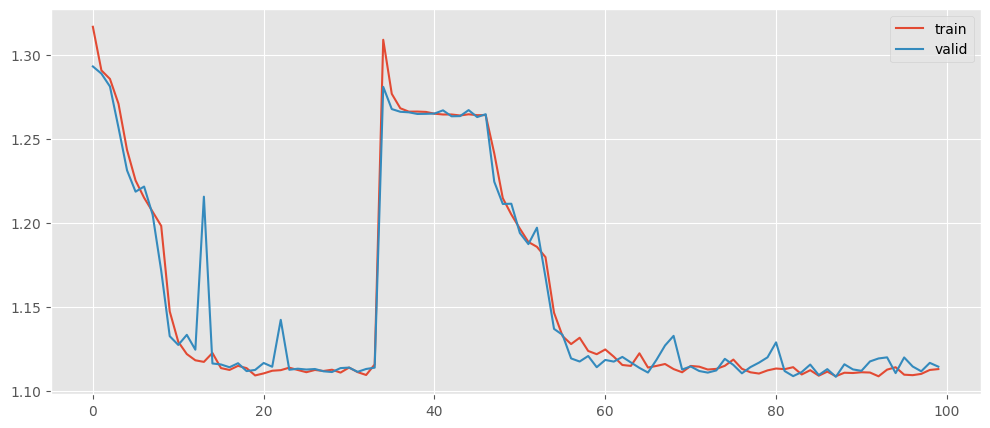

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(train_loss_values, label='train')
ax.plot(valid_loss_values, label='valid')
ax.legend()

plt.show()

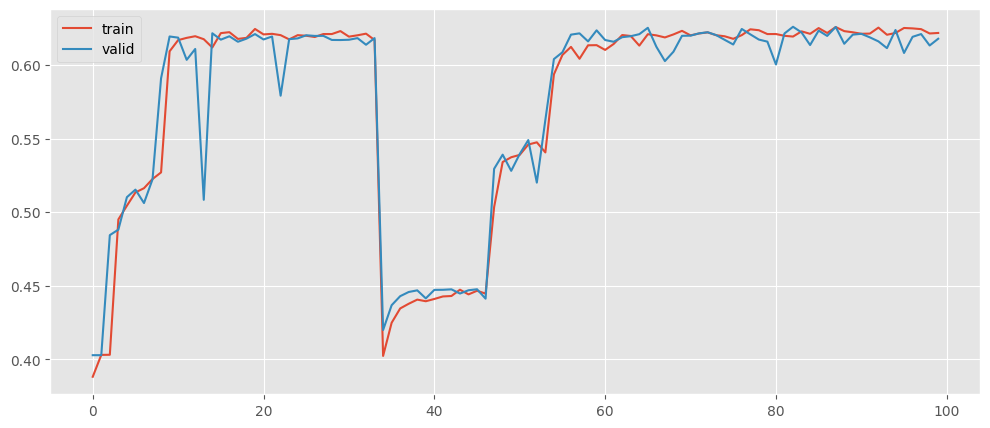

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(train_accuracy_values, label='train')
ax.plot(valid_accuracy_values, label='valid')
ax.legend()

plt.show()

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [41]:
torch.save(model, os.path.join(MODELS_PATH, 'simple_nn.pth'))

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [42]:
model = torch.load(os.path.join(MODELS_PATH, 'simple_nn.pth'))
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)

In [43]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.values.astype(np.float32)))
print(accuracy(test_scores, torch.tensor(y_test.values.astype(np.int64))).item())
print(test_scores.numpy())

0.6178451180458069
[[9.9524033e-01 9.0578801e-08 1.9837096e-03 2.7758146e-03]
 [9.9559587e-01 8.5146155e-08 1.8841529e-03 2.5199051e-03]
 [7.0744716e-03 3.8012416e-07 2.4502065e-03 9.9047500e-01]
 ...
 [9.9565279e-01 8.4264194e-08 1.8680065e-03 2.4790964e-03]
 [9.9421531e-01 1.0560724e-07 2.2540230e-03 3.5306378e-03]
 [9.9565470e-01 8.4233498e-08 1.8673163e-03 2.4778226e-03]]


In [44]:
log_loss(y_test, test_scores.numpy())

2.3810961487682487

In [45]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.values.astype(np.float32)))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)
print(round(accuracy_score(y_test, predicted_classes), 4))

tensor([0, 0, 3,  ..., 0, 0, 0])
0.6178
